In [3]:
import numpy as np
import os
import root_numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [33]:
eval = pd.read_csv('/notebooks/data/samples_for_comparison/sample_test.csv')

# eval_rows = 1000 * 1000
# rows_to_train = 200 * 1000
# skip_rows_eval = np.random.permutation(eval_rows)[rows_to_train:] + 1
# eval = pd.read_csv('data/data_eval.csv', skiprows=skip_rows_eval)

part_codes = {'Ghost':0, 'Electron':11, 'Muon':13, 'Pion':211, 'Kaon':321, 'Proton':2212}

eval_types = np.abs(eval['MCParticleType'])

mc_features = ['Unnamed: 0', 'HasMC', 'MCParticleType', 'MCParticleP', 'MCParticlePt', 'MCVirtualMass', 
               'MCFromB', 'MCFromD', 'MCVertexType', 'MCVertexX', 'MCVertexY', 'MCVertexZ', 
               'piplus_OWNPV_X', 'piplus_OWNPV_Y', 'piplus_OWNPV_Z', 'piplus_OWNPV_XERR', 
               'piplus_OWNPV_YERR', 'piplus_OWNPV_ZERR', 'piplus_OWNPV_CHI2', 'piplus_OWNPV_NDOF', 
               'piplus_IP_OWNPV', 'piplus_IPCHI2_OWNPV', 'nCandidate', 'totCandidates', 'EventInSequence', 
               'TrackHistory', 'TrackType', 'RecoPIDcode']

constant_features = ['TrackMatchChi2', 'TrackCloneDist', 'RichUsedAero']

eval.drop(mc_features + constant_features, axis=1, inplace=1)
print eval.shape

(100000, 77)


Предобработка данных такая:

In [6]:
from sklearn.preprocessing import Imputer

to_log = ['CaloNeutralPrs', 'CaloPrsE', 'CaloHcalE', 'CaloNeutralEcal', 'CaloTrMatch', 'CaloElectronMatch', 'CaloChargedPrs',
          'MuonNShared', 'CaloBremMatch', 'TrackPt', 'TrackP', 'NumDownstreamTracks', 'CaloEcalChi2', 'NumRich1Hits',
          'NumMuonTracks', 'NumTTracks', 'TrackFitMatchChi2', 'TrackDOCA', 'CaloClusChi2', 'TrackFitVeloChi2',
          'CaloBremChi2', 'CaloChargedEcal', 'NumSPDHits', 'NumVeloTracks', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'NumRich2Hits', ]

to_log_negative = ['CaloTrajectoryL', 'MuonMuLL', 'RichDLLbt', 'CombDLLp', 'RichDLLe', 'TrackLikelihood', 'CombDLLk', 
                   'RichDLLp', 'CaloEcalE', 'RichDLLmu', 'RichDLLk']

# CaloChargedSpd - 1 or -999 - заменяем -999 на 0
# CombDLLpi, RichDLLpi  0 or -999 - заменяем -999 на 1

# В остальных колонках заменяем -999 на среднее значение в колонке

def log1p_negative(array):
    negative = array < 0
    array = np.log1p(np.abs(array))
    array[negative] *= -1
    return array

def preprocess_data(X):
    X.loc[:, 'CaloChargedSpd'].replace(-999, 0, inplace=1)
    X.loc[:, ['CombDLLpi', 'RichDLLpi']].replace(-999, 1, inplace=1)
    
    X[X == -999] = np.nan
    X_columns = X.columns

    imp = Imputer()
    X = imp.fit_transform(X)
    X = pd.DataFrame(data=X, columns=X_columns)

    for col in to_log:
        X[col] = np.log1p(X[col])
    for col in to_log_negative:
        X[col] = log1p_negative(X[col])
    return X
eval = preprocess_data(eval)

In [34]:
import cPickle as pickle
from sklearn.metrics import roc_curve, roc_auc_score

def test_model(model_type, part_type):
    model = pickle.load(open('baseline/models/{0}-{1}.pkl'.format(model_type, part_type), 'rb'))
    
    preds = model.predict_proba(eval)[:, 1]
    true_labels = (eval_types == part_codes[part_type]).astype(int)
    roc_auc = roc_auc_score(true_labels, preds)
    fpr, tpr, _ = roc_curve(true_labels, preds)

    result = {}
    result[part_type] = roc_auc, fpr, tpr

    for other_part in part_codes:
        if other_part == part_type:
            continue
        mask = (eval_types == part_codes[other_part]) | (eval_types == part_codes[part_type])
        true_labels = eval_types[mask] == part_codes[part_type]
        preds_other = preds[np.where(mask)]
        result[other_part] = roc_auc_score(true_labels, preds_other)

    return result

    
rocs_kmlp_base = {}
for part_type in part_codes:
    print part_type
    rocs_kmlp_base[part_type] = test_model('kMLP', part_type)
    
# rocs_kbdt = {}
# for part_type in part_codes:
#     print part_type
#     rocs_kbdt[part_type] = test_model('kBDT', part_type)
print 'Done!'

Ghost
Muon
Pion
Kaon
Proton
Electron
Done!


In [16]:
plist = ['Electron', 'Pion', 'Kaon', 'Muon', 'Ghost', 'Proton']

def plot_auc(rocs, model_name, axis=None):
    plt.figure(figsize=(12, 8))
    for part_type in part_codes:
        label = '{0}, {1:0.2f}'.format(part_type, rocs[part_type][part_type][0])
        if axis is None:
            plt.plot(rocs[part_type][part_type][1], rocs[part_type][part_type][2], label=label)
            plt.legend(loc=0, prop={'size':20})
            plt.title('ROC AUC for {0}'.format(model_name))
        else:
            axis.plot(rocs[part_type][part_type][1], rocs[part_type][part_type][2], label=label)
    
    
def get_pairwise_roc_matrix(rocs):
    binary_rocs = np.zeros(shape=(6, 6))
    for index, part_type in enumerate(plist):
        for jndex, other_part in enumerate(plist):
            if index == jndex:
                binary_rocs[index, index] = 1.0
            else:
                binary_rocs[index, jndex] = rocs[part_type][other_part]
                binary_rocs[jndex, index] = rocs[part_type][other_part]
    return binary_rocs
    
def plot_binary_rocs(rocs, model_name, axis=None):
    binary_rocs = get_pairwise_roc_matrix(rocs)
    plt.figure(figsize=(10, 8))
    if axis is None:
        sns.heatmap(binary_rocs, cmap='RdBu_r', xticklabels=plist, yticklabels=plist, annot=1, fmt='.4f')
        plt.title('Pairwise AUC for {0}'.format(model_name))
    else:
        sns.heatmap(binary_rocs, cmap='RdBu_r', xticklabels=plist, yticklabels=plist, annot=1, fmt='.4f', ax=axis)

In [23]:
import cPickle as pickle

with open('rocs_kmlp_preprocessed.p', 'rb') as pkl:
    rocs_kmlp_preprocessed = pickle.load(pkl)

Тренировалась модель 1vsRest, параметры:

In [ ]:
model = TMVAClassifier(method='kMLP',
              features=get_features_for(main_class),
              factory_options="V:!Silent:!Color:!DrawProgressBar",
              H='true',
              V='true',
              EpochMonitoring='true',
              HiddenLayers=int(1.2*train.shape[1]),
              UseRegulator='true',
              ConvergenceImprove = "1e-16",
              ConvergenceTests = "15",
              VarTransform = "Norm",
              NCycles = 50,
              NeuronType = "sigmoid",
              TrainingMethod = "BP",
              EstimatorType = "CE")

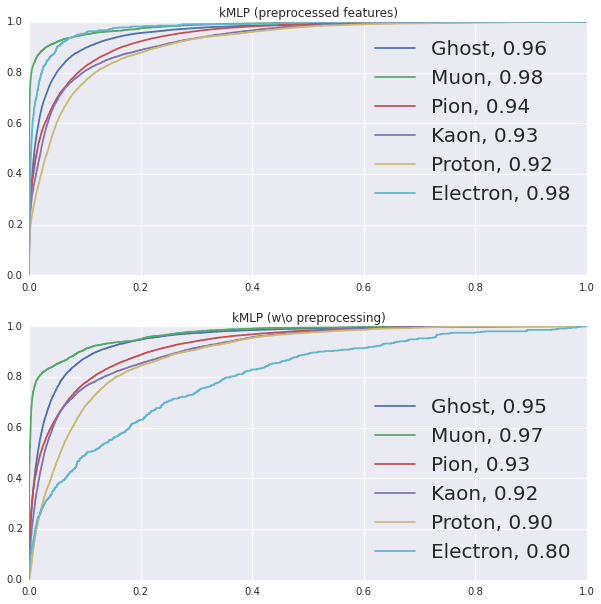

In [31]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
plot_auc(rocs_kmlp_preprocessed, 'kMLP (preprocessed features)', axis=ax1)
plot_auc(rocs_kmlp_base, 'kMLP (w\o preprocessing)', axis=ax2)
ax1.legend(loc=0, prop={'size':20})
ax2.legend(loc=0, prop={'size':20})
ax1.set_title('kMLP (preprocessed features)')
ax2.set_title('kMLP (w\o preprocessing)')

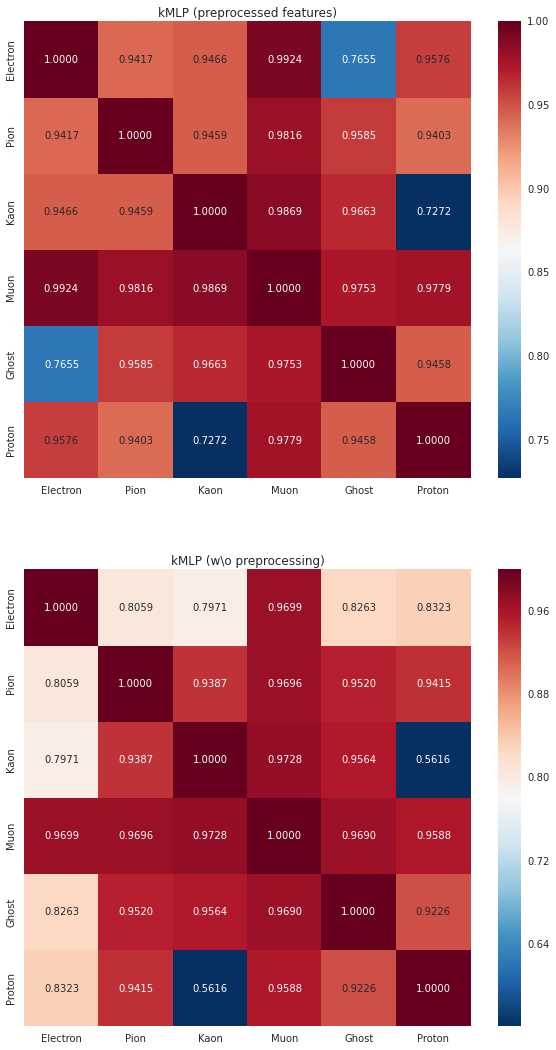

In [35]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 18))
plot_binary_rocs(rocs_kmlp_preprocessed, 'kMLP (preprocessed features)', axis=ax1)
plot_binary_rocs(rocs_kmlp_base, 'kMLP (w\o preprocessing)', axis=ax2)
ax1.legend(loc=0, prop={'size':20})
ax2.legend(loc=0, prop={'size':20})
ax1.set_title('kMLP (preprocessed features)')
ax2.set_title('kMLP (w\o preprocessing)')

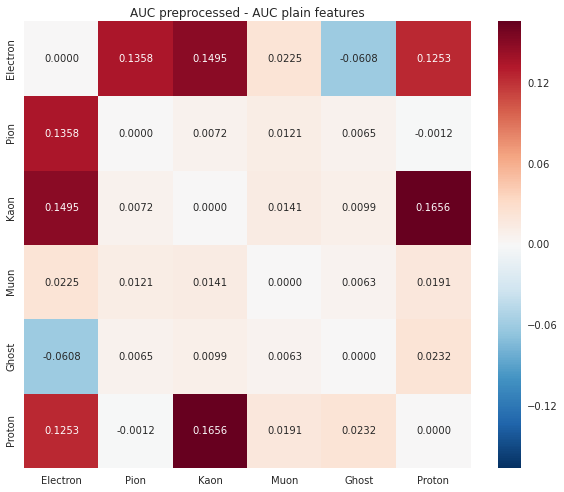

In [40]:
difference = get_pairwise_roc_matrix(rocs_kmlp_preprocessed) - get_pairwise_roc_matrix(rocs_kmlp_base)
plt.figure(figsize=(10, 8))
sns.heatmap(difference, annot=1, fmt='0.4f', xticklabels=plist, yticklabels=plist)
plt.title('AUC preprocessed - AUC plain features')